<a href="https://colab.research.google.com/github/abdo96/Abdallah_Portfolio/blob/main/NLog_for_blob_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLog
    1. convlution operation function
    2. Create Gaussian Kernel function
    3. Give the second derivative of it
    4. Change the value of sigma and multiply each time with the 2nd dev of Gaussian
    5. Apply Non-Maximum Suppression 

In [45]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skimage.exposure import rescale_intensity                 
from scipy import signal
from scipy import ndimage
from scipy import convolve
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import math

In [52]:
filenameLs=[]
for filename in os.listdir('/gdrive/My Drive/Colab Notebooks/Project_Assignement_1/input'):
        filenameLs+=[filename]

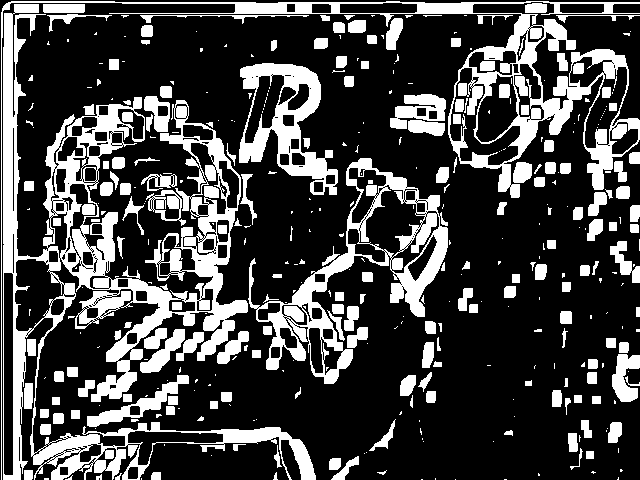

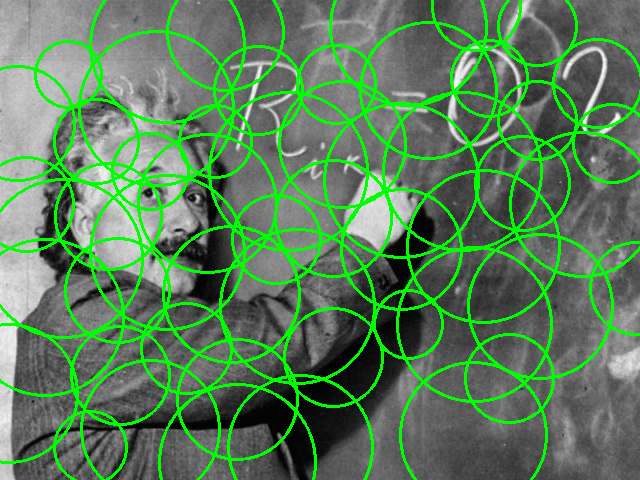

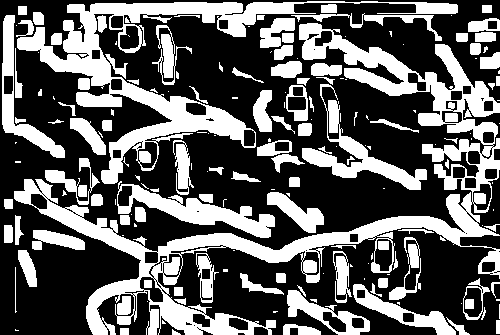

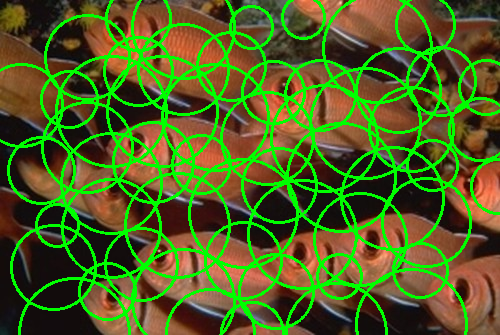

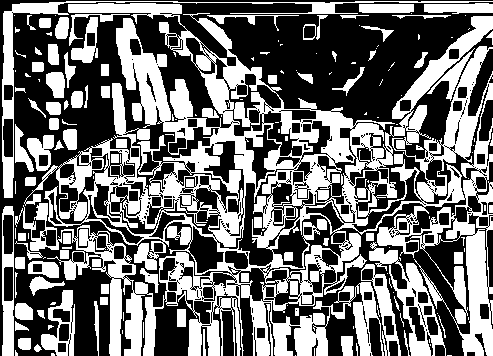

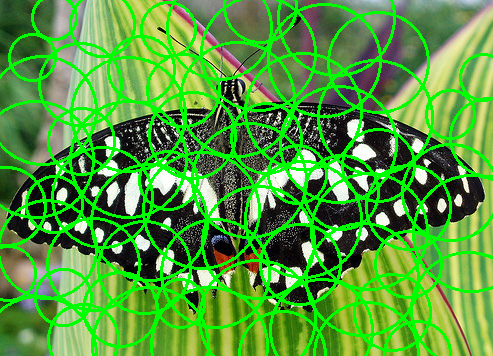

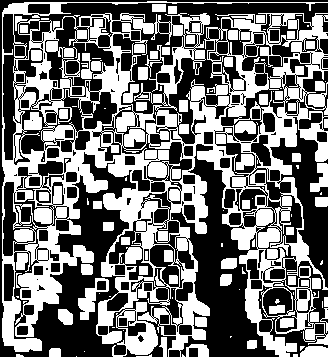

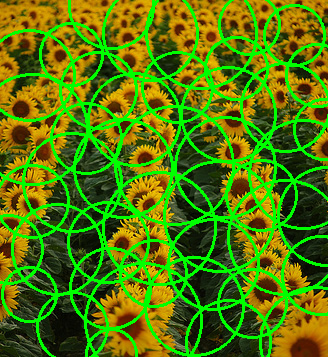

In [62]:
for filename in filenameLs:
       image=cv2.imread(filename)
       grayscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
       scale_space_matrix =Normalized_Lapiachlan_of_Gaussian(3,15,grayscaled_image)
       maximum_filter=non_maximum_suppression(scale_space_matrix,8)
       blobs_drawn=draw_blobs(filename,maximum_filter)
       

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%ls /gdrive/'My Drive'/'Colab Notebooks'/

%cd /gdrive/'My Drive'/'Colab Notebooks'/Project_Assignement_1/input


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
 Big_Sales_Mart/
 Clustering_Breast_Cancer/
 Clustering_Text_still_under_Working/
'Copy of Big_Sales_Mart.ipynb'
'Copy of C1_W2_Assignment.ipynb'
 create_estimator_TF/
 Data_Science_Projects_From_Scratch/
 faces_aligned_small_mirrored_co_aligned_cropped_cleaned-20200706T211534Z-003/
 Location2Vec_Model/
 M5-forcasting_Kaggle_competition/
 Object_Detection_YOLO/
 Parapharsed_model_Task/
 Project_Assignement_1/
 pytorch_Projects/
 scraping_websites/
 Tensorflow_Project/
 Untitled0.ipynb
 Writing_Assistant/
/gdrive/My Drive/Colab Notebooks/Project_Assignement_1/input


# Prepare the image for the operations conv, second dev

In [4]:
def pad_with(vector, pad_width, iaxis, kwargs):

    pad_value = kwargs.get('padder', 10)

    vector[:pad_width[0]] = pad_value

    vector[-pad_width[1]:] = pad_value
    

In [5]:
def conv_operation(newfilter,image,shape='valid',to_show=True):
    """
    take the filter and image and apply the filter over the image
    """
    image_pad = image
    filtered_image=np.zeros((image.shape[0],image.shape[1]),np.float32)
    row_size, col_size=newfilter.shape[0],newfilter.shape[1]
    
    if(shape == 'full'):
        filtered_image =np.pad(filtered_image,newfilter.shape[0] - 1, pad_with, padder=0)
        image_pad = np.pad(image,newfilter.shape[0] - 1, pad_with, padder=0)
    if(shape == 'same'):
        if(newfilter.shape[0]-2 < 0):
             filtered_image =np.pad(filtered_image, 0, pad_with, padder=0)
             image_pad = np.pad(image, 0, pad_with, padder=0)
        else:
             filtered_image =np.pad(filtered_image,newfilter.shape[0]-2, pad_with, padder=0) 
             image_pad = np.pad(image,newfilter.shape[0]-2, pad_with, padder=0)       
    start_row  = 0
    start_col  = 0 

    """
    if(row_size == image.shape[0] and col_size == image.shape[1]):
        return np.sum(np.multiply(newfilter,image))
    """
    while(start_row < image.shape[0]):
         
          if(start_col < image.shape[1]):
              filtered_image[start_row,start_col] = np.sum(np.multiply(newfilter,image_pad[start_row:row_size,start_col:col_size]))
              #print(np.sum(np.multiply(newfilter,image[start_row:row_size,start_col:col_size])))
              col_size = col_size + 1
              start_col = start_col + 1
      
          elif(start_col == image.shape[1]):
              start_col = 0
              row_size = row_size + 1
              start_row =  start_row + 1
              col_size = newfilter.shape[1]   
            
    if(shape=='full'):
             return filtered_image   
    if(to_show == True):                        
             return (filtered_image[:image.shape[0],:image.shape[1]]*255).astype(np.uint8)
    return filtered_image[:image.shape[0],:image.shape[1]]

In [6]:
 def Generate_Gaussian_filter(sigma):
    """
    take the height and the width of filter
    """
    filter_size = 2 * int((4*sigma) + 0.5) + 1
    m = filter_size//2
    n = filter_size//2
    gaussian_matrix=np.zeros((filter_size,filter_size),np.float32)
    for x in range(-m, m+1):
        for y in range(-n, n+1):
            #print(x+n,y+m)
            dominator= 2*np.pi*(sigma**2)
            nominator = np.exp(-(x**2+y**2)/(2*sigma**2))
            gaussian_matrix[x+m,y+n] = (1/dominator)*nominator        
           
    return gaussian_matrix   

In [7]:
def Gaussian_Blur_Image(sigma,image,shape='valid'):
    """
    take the sigma and colored or grayscaled image and generate the filter 
    and convolve the image with filter
    """
    filter_size = 2 * int((4*sigma) + 0.5) + 1
    m = filter_size//2
    n = filter_size//2
    gaussian_matrix=np.zeros((filter_size,filter_size),np.float32)
    for x in range(-m, m+1):
        for y in range(-n, n+1):
            #print(x+n,y+m)
            dominator= 2*np.pi*(sigma**2)
            nominator = np.exp(-(x**2+y**2)/(2*sigma**2))
            gaussian_matrix[x+m,y+n] = (1/dominator)*nominator        
    filtered_image = np.zeros_like(image, dtype=np.float32)        
    for  c in range(3):
        filtered_image[:,:,c]=conv_operation(gaussian_matrix,image[:,:,c],'same')

    return (filtered_image.astype(np.uint8))      

# 2. Manually apply first dev and second by conv operation :
             
            1. First derivative: [-1,1] * Gaussain filter on two directions and sum 
            2. Second derivative: first dev * first dev

In [ ]:
# first_dev
dx_guassian_first_dev = conv_operation(np.array([[-1,1]]*25).reshape(25,2),Generate_Gaussian_filter(3),shape='same',to_show=False)
dy_guassian_first_dev = conv_operation(np.array([[1,-1]]).reshape(1,2),Generate_Gaussian_filter(3),shape='same',to_show=False)

In [ ]:
# second derivative by multiply first derivative filter to first derivative filter
second_dev_image_dxx=conv_operation(dx_guassian_first_dev,dx_guassian_first_dev,'same',to_show=False)
second_dev_image_dyy=conv_operation(dy_guassian_first_dev,dy_guassian_first_dev,'same',to_show=False)
second_dev_image_dxy=conv_operation(dx_guassian_first_dev,dy_guassian_first_dev,'same',to_show=False)
total_dev = second_dev_image_dxx+second_dev_image_dyy+second_dev_image_dxy

In [ ]:
# apply second and first dev on the image for edge detection and blob detection
first_dev_image=conv_operation(dx_guassian_first_dev+dy_guassian_first_dev,grayscaled_image,'same',to_show=True)
second_dev_image=conv_operation(total_dev,grayscaled_image,'same',to_show=True)

In [ ]:
first_dev_image_dx.shape
first_dev_image=conv_operation(dx_guassian_first_dev+dy_guassian_first_dev,grayscaled_image,'same',to_show=True)
second_dev_image=conv_operation(total_dev,grayscaled_image,'same',to_show=True)
cv2_imshow(image_blurred),cv2_imshow(filtered_image)
new_img_dyy = image_dyy*2
new_img_dxx = image_dxx*2
cv2_imshow(first_dev_image)
cv2_imshow(first_dev_image_dy)
cv2_imshow(image_dyy)
cv2_imshow(second_dev_image)
cv2_imshow(image_dev)
concatenated_dev.shape

  # 3.  Steps for Blob detection:


 
    1. Generate Lapiachlan Gaussaian.
    
    2. Normalized by sigma and change the intial sigma square by const^k.
    
    3. Non-maximum suppression to get the maximum filter
    
    4. Extract the maximum indices from the filters and blob size(sigma)
    
    5. Draw blobs


In [8]:
def Generate_Lapiachlan_of_Gaussian(sigma):
    """
     take the sigma and generate the second derivative of Gaussian
    """
    filter_size = 2 * int((4*sigma) + 0.5) + 1
    m = filter_size//2
    n = filter_size//2
    lapiachlan_gaussian_matrix=np.zeros((filter_size,filter_size),np.float32)
    for x in range(-m, m+1):
        for y in range(-n, n+1):
            #print(x+n,y+m)
            lapiachlan_gaussian_matrix[x+m,y+n]= -(1/(np.pi*(sigma**4))) * (1-(x**2+y**2)/(2*(sigma**2))) * np.exp(-(x**2+y**2)/(2*(sigma**2)))
           
    return lapiachlan_gaussian_matrix





In [9]:
def Normalized_Lapiachlan_of_Gaussian(initial_sigma,num_of_sigmas,img):
    """
    this function take sigma and build NLog to build scale space and 
    detect the blob poistion and size(sigma)
    """
    const = 1.2
    k = 1
    # calculate the second derivative of gaussian
    lapiachlan_gaussian_matrix=Generate_Lapiachlan_of_Gaussian(initial_sigma)  
    
    # initiate the scale space     
    scale_space = np.zeros((grayscaled_image.shape[0],grayscaled_image.shape[1],num_of_sigmas),np.float32)
    
    # Generate the scale spece based on the different charateristic scales sigma
    updated_sigma=(initial_sigma**2)
    sigmaLs = []
    sigmaLs += [updated_sigma]
    for k in range(1,num_of_sigmas):
       scale_space[:,:,k-1] = conv_operation(np.multiply(updated_sigma,lapiachlan_gaussian_matrix),img,'same',to_show=False)
       updated_sigma = (initial_sigma**2)*(const**k)
       sigmaLs+=[updated_sigma] 
    return scale_space,sigmaLs

In [53]:
def non_maximum_suppression(scale_space,size_of_blob):
  """  
   Calculate the non-maximum suppresssion for the scale space
  """
  # Non-maximum suppression over the pixels
  maximum_filter=ndimage.maximum_filter(scale_space_matrix[0],size=size_of_blob)
  index_of_maximum_sigma=np.argmax(maximum_filter,axis=2)[0][0]
  maximum_filter=maximum_filter[:,:,index_of_maximum_sigma]

  return maximum_filter

 

In [61]:
def draw_blobs(image_path,maximum_filter):
  """
   take the image and draw the blobs over the image
  """

  # Read input image
  img = cv2.imread(image_path)


  # Apply adaptive threshold with gaussian size 15x15
  thresh = cv2.adaptiveThreshold(maximum_filter.astype(np.uint8), 255, adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C, thresholdType=cv2.THRESH_BINARY, blockSize=15, C=0)

  # Use threshold for finding dark pixels - needs to be masked
  _, dark_mask = cv2.threshold(maximum_filter.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  cv2_imshow(dark_mask)  

  # Mask the dark pixels.
  thresh = thresh & dark_mask

  # Use "opening" morphological operation - cleaning up.
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))

  rows, cols = thresh.shape

  # Use HoughCircles for finding circles
  circles = cv2.HoughCircles(thresh, cv2.HOUGH_GRADIENT, 1.5, minDist=rows//8, param1=50, param2=30, minRadius=rows//8, maxRadius=rows//3)

  # mask will be the desired mask (filled circle)3
  mask = np.zeros_like(maximum_filter)

  # Iterate circles
  for c in circles[0,:]:
    # Draw green circle on the image for testing
    cv2.circle(img, (c[0], c[1]), int(c[2]//2), (0, 255, 0), 2)

    # Draw filled circle for creating the mask
    cv2.circle(mask, (c[0], c[1]), int(c[2]//2), 255, cv2.FILLED)
  cv2_imshow(img)  

In [38]:
"""
  for k in range(0,levels):
       non_max_supp[:,:,k]=ndimage.maximum_filter(scale_space[0][:,:,k],size=scale_space[1][k])
  # Non-maximum suppression over the scales 
  # try to check the maximum values in the three dimension but two neighbors close to each to get the maximum
  # the idea is to check two neighbors and choose the maximum value for each neighbour so the maximum blob will 
  for k in range(1,levels):
     #print(max(1,k-1),min(levels,k+1))
     non_max_supp[:,:,k-1]=np.amax(non_max_supp[:,:,max(1,k-1):min(levels,k+1)],axis=2) 
  '''
  for k in range(1,levels):   
     nparray = np.delete(non_max_supp[:,:,k-1], np.where(
    (non_max_supp[:,:,k-1] >= 5) & (nparray <= 20))[0], axis=0)   
  print(np.amax(non_max_supp[:,:,:],axis=2).shape)
  '''
"""
"""
  non_repeated_elements=[]
  blobs_pos_ls = []
  #print(levels)
  sigma_pos_ls = []
  for k in range(0,levels):
    current_level = non_max_supp[:,:,k] 
    current_level_indices = np.where(current_level >= threshold)
    row_indices = current_level_indices[0]
    col_indices = current_level_indices[1]
    #print(row_indices)
    if(row_indices != [] or col_indices != []):
       blob_pos=list(zip(row_indices,col_indices))
       #print(blob_pos)
       #blob_pos = np.array(blob_pos)
       blobs_pos_ls+=[set(blob_pos),sigma]
"""  

"""
im = Image.open('fishes.jpg')
# Create figure and axes
fig, ax = plt.subplots()
# Display the image
ax.imshow(im)
const = 1.2
sigma = 4
# Create a circle patch
for idx_pos in range(0,len(blob_pos_ls),335):
        k = sigma**const
        ax.add_patch(patches.Circle((blob_pos_ls[idx_pos][1],blob_pos_ls[idx_pos][0]), radius=math.sqrt(scale_space_matrix[1][4])*k,color='b',linewidth='5',fill=False))
        k = k + 0.1

# Add the patch to the Axes
plt.show()
"""
"""
from scipy import ndimage, misc
import matplotlib.pyplot as plt
fig = plt.figure()
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = misc.ascent()
print(ascent.shape)
result = ndimage.maximum_filter(ascent, size=20)
ax1.imshow(ascent)
ax2.imshow(result)
plt.show()
indices_of_blobs=list(blob_pos_ls[0].intersection(*blob_pos_ls[1:15]))
"""


'\nfrom scipy import ndimage, misc\nimport matplotlib.pyplot as plt\nfig = plt.figure()\nplt.gray()  # show the filtered result in grayscale\nax1 = fig.add_subplot(121)  # left side\nax2 = fig.add_subplot(122)  # right side\nascent = misc.ascent()\nprint(ascent.shape)\nresult = ndimage.maximum_filter(ascent, size=20)\nax1.imshow(ascent)\nax2.imshow(result)\nplt.show()\n'